In [2]:
import qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd
from mitiq import Executor, MeasurementResult, Observable
from cirq import DensityMatrixSimulator, depolarize
from mitiq.interface import convert_to_mitiq
import mitiq
from mitiq import zne, benchmarks, pec
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise

import qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.providers.aer.noise import NoiseModel
from qiskit_aer import AerSimulator
import numpy as np
import pandas as pd
from mitiq import Executor, MeasurementResult, Observable
from cirq import DensityMatrixSimulator, depolarize
from mitiq.interface import convert_to_mitiq
import mitiq
from mitiq import zne, benchmarks, pec
from mitiq.pec.representations import find_optimal_representation
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise
from mitiq.pec.channels import kraus_to_super
from qiskit.circuit.library import RZGate, SXGate, CXGate
from qiskit.circuit.library.generalized_gates import PauliGate
from qiskit.extensions import UnitaryGate
import time
import copy
import pdb
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.tools.visualization import *
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)

# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)



/tmp/ipykernel_34661/4123567062.py:60: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,


In [3]:
noise_dict = pd.read_pickle('./NoiseModel/fakecairo.pkl')
# Load the noise model from the dictionary
noise_model = NoiseModel.from_dict(noise_dict)
backend = AerSimulator(method = "density_matrix", noise_model = noise_model)

/tmp/ipykernel_34661/3721001093.py:3: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(noise_dict)


In [4]:
shots = 1024
qubits = [0,1,2,3]
num_qubits = len(qubits)

exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐         
   q_0: ─░─┤M├─────────
         ░ └╥┘┌─┐      
   q_1: ─░──╫─┤M├──────
         ░  ║ └╥┘┌─┐   
   q_2: ─░──╫──╫─┤M├───
         ░  ║  ║ └╥┘┌─┐
   q_3: ─░──╫──╫──╫─┤M├
         ░  ║  ║  ║ └╥┘
meas: 4/════╩══╩══╩══╩═
            0  1  2  3 
        ┌───┐ ░ ┌─┐         
   q_0: ┤ X ├─░─┤M├─────────
        ├───┤ ░ └╥┘┌─┐      
   q_1: ┤ X ├─░──╫─┤M├──────
        ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├─░──╫──╫─┤M├───
        ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════╩══╩══╩══╩═
                 0  1  2  3 


In [5]:
exp.analysis.set_options(plot=True)
result = exp.run(backend)
# mitigator = result.analysis_results(0).value

In [6]:
from cirq import LineQubit, Circuit, X, measure_each

from mitiq.observable.observable import Observable
from mitiq.observable.pauli import PauliString

qreg = [LineQubit(i) for i in range(2)]
circuit = Circuit(X.on_each(*qreg))
observable = Observable(PauliString("ZI"), PauliString("IZ"))

print(circuit)

0: ───X───

1: ───X───


In [7]:
from functools import partial

import numpy as np
from cirq.experiments.single_qubit_readout_calibration_test import (
    NoisySingleQubitReadoutSampler,
)

from mitiq import MeasurementResult

def noisy_readout_executor(circuit, p0, p1, shots=8192) -> MeasurementResult:
    # Replace with code based on your frontend and backend.
    simulator = NoisySingleQubitReadoutSampler(p0, p1)
    result = simulator.run(circuit, repetitions=shots)
    bitstrings = np.column_stack(list(result.measurements.values()))
    return MeasurementResult(bitstrings, qubit_indices = (0, 1))

ModuleNotFoundError: No module named 'pytest'

In [ ]:
from mitiq.raw import execute as raw_execute

# Compute the expectation value of the observable.
# Use a noisy executor that has a 25% chance of bit flipping
p_flip = 0.25
noisy_executor = partial(noisy_readout_executor, p0=p_flip, p1=p_flip)
noisy_value = raw_execute(circuit, noisy_executor, observable)

ideal_executor = partial(noisy_readout_executor, p0=0, p1=0)
ideal_value = raw_execute(circuit, ideal_executor, observable)
error = abs((ideal_value - noisy_value)/ideal_value)
print(f"Error without mitigation: {error:.3}")

In [9]:
qr = qiskit.QuantumRegister(5)
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])
qubit_list = [[0],[1],[2],[3],[4]]
cal_circuits, mit_pattern = tensored_meas_cal(mit_pattern=qubit_list, qr=qr, circlabel='mcal')
# meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
cal_circuits[0].draw()

░ ┌─┐            
q0_0: ─░─┤M├────────────
       ░ └╥┘┌─┐         
q0_1: ─░──╫─┤M├─────────
       ░  ║ └╥┘┌─┐      
q0_2: ─░──╫──╫─┤M├──────
       ░  ║  ║ └╥┘┌─┐   
q0_3: ─░──╫──╫──╫─┤M├───
       ░  ║  ║  ║ └╥┘┌─┐
q0_4: ─░──╫──╫──╫──╫─┤M├
       ░  ║  ║  ║  ║ └╥┘
c1: 5/════╩══╩══╩══╩══╩═
          0  1  2  3  4

In [14]:
noise_dict = pd.read_pickle('./NoiseModel/fakecairo.pkl')
# Load the noise model from the dictionary
noise_model = NoiseModel.from_dict(noise_dict)

backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(cal_circuits, backend=backend, shots=10000, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern, circlabel='mcal')
# Results without mitigation
raw_counts = cal_results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(cal_results)
mitigated_counts = mitigated_results.get_counts()

print(meas_fitter.cal_matrices)

/tmp/ipykernel_34661/1110123049.py:3: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(noise_dict)


method: SLSQPmethod: SLSQP

[array([[0.9934, 0.0097],
       [0.0066, 0.9903]]), array([[0.9951, 0.0102],
       [0.0049, 0.9898]]), array([[0.9951, 0.0111],
       [0.0049, 0.9889]]), array([[0.9933, 0.0081],
       [0.0067, 0.9919]]), array([[0.9911, 0.0163],
       [0.0089, 0.9837]])]


In [ ]:
# raw_counts

In [ ]:
# mitigated_counts
# plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

In [13]:
a = np.array([[0.9932, 0.0068], [0.010199999999999987, 0.9898]])
# b = np.array([[0.9932, 0.0068], [0.010199999999999987, 0.9898]])
# c = a @ b
# d = np.linalg.inv(b)
meas_fitter.cal_matrices[0] = a.T
# print(c)
# print(d)
# print(d @ b)
print(meas_fitter.cal_matrices)

[[0.98518428 0.01921572]
 [0.01821572 0.97738428]]
[[ 1.0069176 -0.0069176]
 [-0.0103764  1.0103764]]
[[ 1.00000000e+00  1.56092501e-19]
 [-1.48254360e-18  1.00000000e+00]]
[array([[0.9918, 0.0082],
       [0.0126, 0.9874]]), array([[0.996 , 0.0113],
       [0.004 , 0.9887]]), array([[0.9938, 0.0118],
       [0.0062, 0.9882]]), array([[0.9933, 0.007 ],
       [0.0067, 0.993 ]]), array([[0.9894, 0.0164],
       [0.0106, 0.9836]])]


In [36]:
meas_fitter

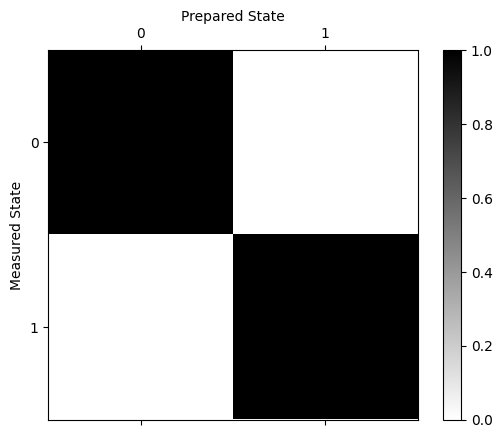

In [45]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

In [50]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity(cal_index=0))

# # What is the measurement fidelity of Q0?
# print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
#     label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 1.008647
